In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
import platform
import psutil
import skforecast
import pandas as pd
import numpy as np
import scipy
import sklearn


import numpy as np
import pandas as pd
import time
import warnings
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
%load_ext pyinstrument 

## Information system and libraries

In [3]:
# Versions
# ==============================================================================
print(f"Python version: {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version: {skforecast.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"psutil version: {psutil.__version__}")
print("")

# Computer information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version: 3.10.11
scikit-learn version: 1.2.2
skforecast version: 0.9.0
pandas version: 2.0.2
numpy version: 1.24.3
scipy version: 1.10.1
psutil version: 5.9.5

Computer network name: ITES015-NB0029
Machine type: AMD64
Processor type: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel
Platform type: Windows-10-10.0.19044-SP0
Operating system: Windows
Operating system release: 10
Operating system version: 10.0.19044
Number of physical cores: 8
Number of logical cores: 16


## Data

In [4]:
# Data
# ==============================================================================
n = 10_000
rgn = np.random.default_rng(seed=123)
y = pd.Series(rgn.random(size=(n)), name="y")
exog = pd.DataFrame(rgn.random(size=(n, 10)))
exog.columns = [f"col_{i}" for i in range(exog.shape[1])]
y_train = y[:-int(n/2)]
display(y.head())
display(exog.head())   

0    0.682352
1    0.053821
2    0.220360
3    0.184372
4    0.175906
Name: y, dtype: float64

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,0.855557,0.528149,0.611974,0.809502,0.999681,0.261925,0.480293,0.361009,0.843979,0.596611
1,0.002650,0.705236,0.547129,0.819472,0.705629,0.191310,0.617129,0.441121,0.914477,0.438860
2,0.392213,0.349656,0.258877,0.920072,0.427726,0.032372,0.500220,0.929874,0.277166,0.961383
3,0.289545,0.150200,0.214419,0.014987,0.574105,0.562479,0.631097,0.765738,0.863536,0.562381
4,0.999299,0.077688,0.868944,0.913900,0.158110,0.145379,0.334003,0.429158,0.236270,0.326537


## Profiling ForecasterAutoreg

In [5]:
warnings.filterwarnings("ignore")

In [6]:
# Forecaster
# ==============================================================================
print("-----------------")
print("ForecasterAutoreg")
print("-----------------")


regressors = [
    Ridge(random_state=77),
    LGBMRegressor(random_state=77, n_jobs=1),
    LGBMRegressor(random_state=77, n_jobs=-1),
    HistGradientBoostingRegressor(random_state=77),
    RandomForestRegressor(random_state=77, n_jobs=1),
    RandomForestRegressor(random_state=77, n_jobs=-1),
]
param_grids = [
    {'alpha': [0.1, 1, 10]},
    {'n_estimators': [50, 200], 'max_depth': [5, 10]},
    {'n_estimators': [50, 200], 'max_depth': [5, 10]},
    {'max_iter': [50, 200], 'max_depth': [5, 10]},
    {'n_estimators': [50, 200], 'max_depth': [5, 10]},
]
lags_grid = [50, 50, 50]

elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterAutoreg(regressor=regressor, lags=50)
    
    # Profiling fit
    # ==============================================================================
    print("Profiling fit")
    start = time.time()
    forecaster.fit(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling create_train_X_y
    # ==============================================================================
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    # Profiling backtesting refit and parallel
    # ==============================================================================
    print("Profiling backtesting refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting refit and no parallel
    # ==============================================================================
    print("Profiling backtesting refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and parallel
    # ==============================================================================
    print("Profiling backtesting no refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and no parallel
    # ==============================================================================
    print("Profiling backtesting no refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)    
    
    # gridSearch no refit parallel
    # ==============================================================================
    print("Profiling gridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = 24,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = -1
            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # GridSearch no refit no parallel
    # ==============================================================================
    print("Profiling gridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = 24,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = 1
            )
    end = time.time()
    elapsed_times.append(end - start)    

-----------------
ForecasterAutoreg
-----------------

Ridge(random_state=77) {'alpha': [0.1, 1, 10]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
Number of models compared: 9.
Profiling gridSearch no refit no parallel
Number of models compared: 9.

LGBMRegressor(n_jobs=1, random_state=77) {'n_estimators': [50, 200], 'max_depth': [5, 10]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch no refit parallel
Number of models compared: 12.
Profiling gridSearch no refit no parallel
Number of models compared: 12.

LGBMRegressor(random_state=77) {'n_estimators': [50, 200], 'max_depth': [5, 10]}

Pro

In [7]:
methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
     "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
     "method": np.tile(methods, len(regressors)),
     "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results.to_csv("profiling_results_forecasterautoreg.csv", index=False)

results.sort_values(by=["regressor", "method", "parallel"])

,regressor,method,elapsed_time,parallel
13,"LGBMRegressor(n_jobs=1, random_state=77)",backtest_no_refit,2.024145,False
12,"LGBMRegressor(n_jobs=1, random_state=77)",backtest_no_refit,3.180033,True
11,"LGBMRegressor(n_jobs=1, random_state=77)",backtest_refit,98.574591,False
10,"LGBMRegressor(n_jobs=1, random_state=77)",backtest_refit,20.674937,True
9,"LGBMRegressor(n_jobs=1, random_state=77)",create_train_X_y,0.006617,False
8,"LGBMRegressor(n_jobs=1, random_state=77)",fit,0.561093,False
15,"LGBMRegressor(n_jobs=1, random_state=77)",gridSearch_no_refit,12.753767,False
14,"LGBMRegressor(n_jobs=1, random_state=77)",gridSearch_no_refit,23.234044,True
21,LGBMRegressor(random_state=77),backtest_no_refit,1.071470,False
20,LGBMRegressor(random_state=77),backtest_no_refit,1.767469,True


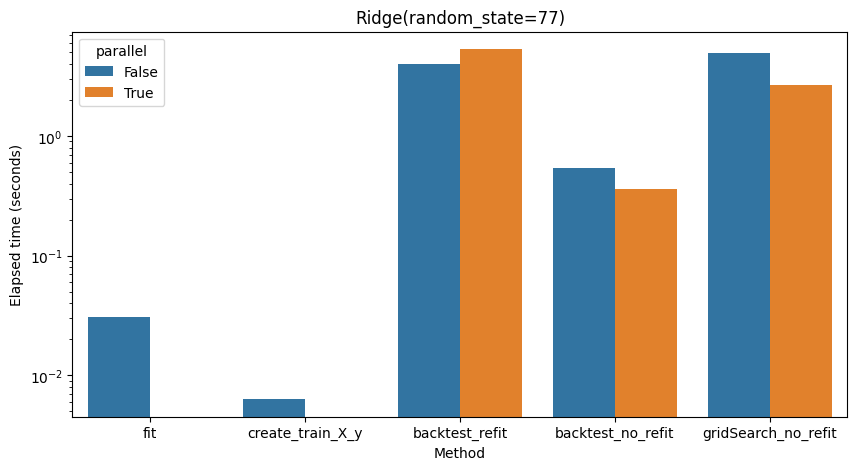

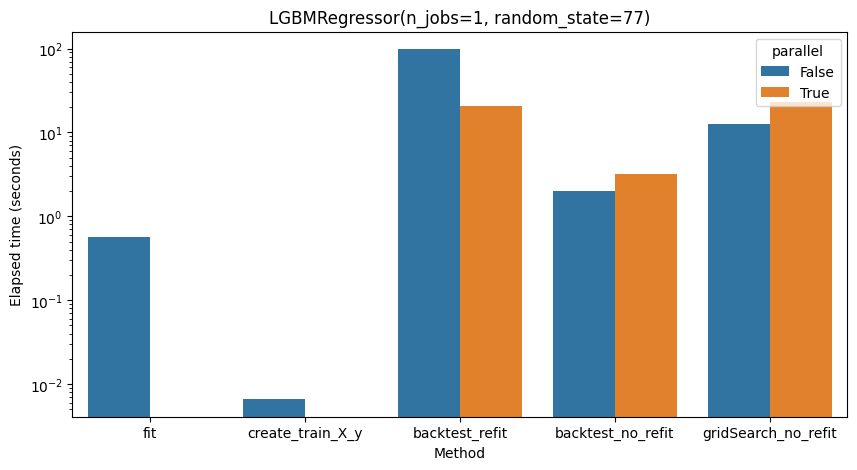

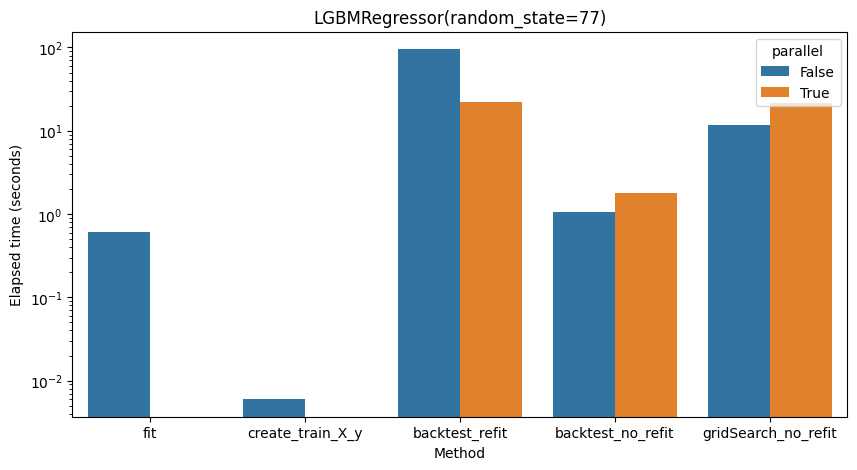

In [8]:
for regressor in results.regressor.unique():
    df = results[results.regressor == regressor].copy()
    #Plot results in a bar plot with a diferent color por parallel and no parallel
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(data=df, x="method", y="elapsed_time", hue="parallel", ax=ax)
    ax.set_title(regressor)
    ax.set_ylabel("Elapsed time (seconds)")
    ax.set_xlabel("Method")
    ax.set_yscale('log')
    plt.show()
    

In [8]:
regressor =LGBMRegressor(random_state=77, n_jobs=-1)
forecaster = ForecasterAutoreg(regressor=regressor, lags=50)

print("Profiling backtesting refit and parallel")
print(regressor)
start = time.time()
metric, backtest_predictions = backtesting_forecaster(
                            forecaster          = forecaster,
                                y                   = y,
                                exog                = exog,
                                initial_train_size  = len(y_train),
                                fixed_train_size    = False,
                                steps               = 24,
                                metric              = 'mean_squared_error',
                                refit               = True,
                                interval            = None,
                                n_boot              = 500,
                                random_state        = 123,
                                in_sample_residuals = True,
                                verbose             = False,
                                show_progress       = False,
                                n_jobs              = -1
                        )
end = time.time()
print(end - start)

Profiling backtesting refit and parallel
LGBMRegressor(random_state=77)
49.63281559944153


In [9]:
regressor =LGBMRegressor(random_state=77, n_jobs=-1)
forecaster = ForecasterAutoreg(regressor=regressor, lags=50)
print("Profiling gridSearch refit parallel")
print(regressor)
param_grid = [
    {'n_estimators': [50, 200], 'max_depth': [5, 10]}
]
lags_grid = [50, 50, 50]
start = time.time()
results_grid = grid_search_forecaster(
                forecaster          = forecaster,
                y                   = y,
                exog                = exog,
                initial_train_size  = len(y_train),
                steps               = 24,
                param_grid         = param_grid,
                lags_grid          = lags_grid,
                refit              = True,
                metric             = 'mean_squared_error',
                fixed_train_size   = False,
                return_best        = False,
                verbose            = False,
                show_progress      = False,
                n_jobs             = -1
        )
end = time.time()
print(end - start)

Profiling gridSearch refit parallel
LGBMRegressor(random_state=77)
Number of models compared: 12.
547.3292081356049


## Profiling ForecasterAutoregDirect

In [10]:
# Forecaster
# ==============================================================================
print("-----------------------")
print("ForecasterAutoregDirect")
print("-----------------------")


regressors = [
    Ridge(random_state=77),
    LGBMRegressor(random_state=77, n_jobs=1),
    LGBMRegressor(random_state=77, n_jobs=-1),
    HistGradientBoostingRegressor(random_state=77),
    RandomForestRegressor(random_state=77, n_jobs=1),
    RandomForestRegressor(random_state=77, n_jobs=-1),
]
param_grids = [
    {'alpha': [0.1, 1, 10]},
    {'n_estimators': [50, 200], 'max_depth': [5, 10]},
    {'n_estimators': [50, 200], 'max_depth': [5, 10]},
    {'max_iter': [50, 200], 'max_depth': [5, 10]},
    {'n_estimators': [50, 200], 'max_depth': [5, 10]},
]
lags_grid = [50, 50, 50]

elapsed_times = []

for regressor, param_grid in zip(regressors, param_grids):
    print("")
    print(regressor, param_grid)
    print("")
    forecaster = ForecasterAutoregDirect(regressor=regressor, lags=50, steps=24)
    
    # Profiling fit
    # ==============================================================================
    print("Profiling fit")
    start = time.time()
    forecaster.fit(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling create_train_X_y
    # ==============================================================================
    print("Profiling create_train_X_y")
    start = time.time()
    _ = forecaster.create_train_X_y(y=y, exog=exog)
    end = time.time()
    elapsed_times.append(end - start)

    # Profiling backtesting refit and parallel
    # ==============================================================================
    print("Profiling backtesting refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting refit and no parallel
    # ==============================================================================
    print("Profiling backtesting refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = True,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and parallel
    # ==============================================================================
    print("Profiling backtesting no refit and parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = -1
                            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # Profiling backtesting no refit and no parallel
    # ==============================================================================
    print("Profiling backtesting no refit and no parallel")
    start = time.time()
    metric, backtest_predictions = backtesting_forecaster(
                                    forecaster          = forecaster,
                                    y                   = y,
                                    exog                = exog,
                                    initial_train_size  = len(y_train),
                                    fixed_train_size    = False,
                                    steps               = 24,
                                    metric              = 'mean_squared_error',
                                    refit               = False,
                                    interval            = None,
                                    n_boot              = 500,
                                    random_state        = 123,
                                    in_sample_residuals = True,
                                    verbose             = False,
                                    show_progress       = False,
                                    n_jobs              = 1
                            )
    end = time.time()
    elapsed_times.append(end - start)    
    
    # gridSearch no refit parallel
    # ==============================================================================
    print("Profiling gridSearch no refit parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = 24,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = -1
            )
    end = time.time()
    elapsed_times.append(end - start)
    
    # GridSearch no refit no parallel
    # ==============================================================================
    print("Profiling gridSearch no refit no parallel")
    start = time.time()
    results_grid = grid_search_forecaster(
                    forecaster          = forecaster,
                    y                   = y,
                    exog                = exog,
                    initial_train_size  = len(y_train),
                    steps               = 24,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    fixed_train_size   = False,
                    return_best        = False,
                    verbose            = False,
                    show_progress      = False,
                    n_jobs             = 1
            )
    end = time.time()
    elapsed_times.append(end - start)    

-----------------------
ForecasterAutoregDirect
-----------------------

Ridge(random_state=77) {'alpha': [0.1, 1, 10]}

Profiling fit
Profiling create_train_X_y
Profiling backtesting refit and parallel
Profiling backtesting refit and no parallel
Profiling backtesting no refit and parallel
Profiling backtesting no refit and no parallel
Profiling gridSearch refit parallel
Number of models compared: 9.
Profiling gridSearch refit no parallel
Number of models compared: 9.


In [1]:
methods = [
    "fit",
    "create_train_X_y",
    "backtest_refit_parallel",
    "backtest_refit_noparallel",
    "backtest_no_refit_parallel",
    "backtest_no_refit_noparallel",
    "gridSearch_no_refit_parallel",
    "gridSearch_no_refit_noparallel"
]

results = pd.DataFrame({
     "regressor": np.repeat(np.array([str(regressor) for regressor in regressors]), len(methods)),
     "method": np.tile(methods, len(regressors)),
     "elapsed_time": elapsed_times
})

results['parallel'] = results.method.str.contains("_parallel")
results['method'] = results.method.str.replace("_parallel", "")
results['method'] = results.method.str.replace("_noparallel", "")
results.to_csv("profiling_results_forecasterautoregdirect.csv", index=False)


results.sort_values(by=["regressor", "method", "parallel"])

NameError: name 'pd' is not defined